# Homework 2: Autoencoder Practice Problem <15 points in total>
In this question, we will try to implement **autoencoder(AE)** for dimensionality reduction using `pytorch`. 

We will use our model on the peripheral blood mononuclear cells(PBMCs) single-cell gene expression dataset.

`counts_PBMC.csv` is a 3000 x 3000 matrix of gene expression levels of 3000 genes (each column represents a gene) for 3000 individual cells (each row represents a cell). 

`celltypes_PBMC.txt` stores the corresponding cell type for each individual cell. It is ordered in the same way with the cells in `counts_PBMC.csv`.



An autoencoder consists of two parts: 

* The encoder network encodes the high dimensional data into a low dimensional embedding. 

* The decoder network reconstructs the input high dimensional data from the embedding.

An autoencoder learns to represent the features by minimizing the reconstruction error between the input and output data.

We can use the low dimensional embedding of a trained encoder to represent a dataset in lower dimensions. 


## Introduction:

In this notebook, we will first look at the dataset together. <br>
Next, you will need to implement an autoencoder with an assigned architecture. <br>
Then, you will design your own autoencoder architecture and tune the hyperparameters.

## To sum up: What needs to be done-

#### Task 1. Complete the code for `autoencoder` <5 points>

You will get full credit as long as the architecture is correct

#### Task 2. Design your own  `myautoencoder` and hyperparameters <10 points>

You will need to improve the embedding from the one from an untrained model to get full credit.

##### <font color='Red'>For this programming problem, you only need to submit the code (notebook) on gradescope. You don't need to write anything on the assignment PDF file</font>



## Environmet

To run this code, you may have to install `numpy`, `torch`, `sckikit-learn`, `pandas`, and `matplotlib`, if you haven't done so and are running locally.

In [ ]:
#import the packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Read in the data
First, let's read in the PBMCs data that we will use for the training. 

In [ ]:
!wget https://dl.dropbox.com/s/rwpa4reamun9je9/counts_PBMC.csv?dl=1 -O counts_PBMC.csv
!wget https://dl.dropbox.com/s/2p60xhx5x7theex/celltypes_PBMC.txt?dl=1 -O celltypes_PBMC.txt

--2023-03-14 00:45:44--  https://dl.dropbox.com/s/rwpa4reamun9je9/counts_PBMC.csv?dl=1
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/rwpa4reamun9je9/counts_PBMC.csv?dl=1 [following]
--2023-03-14 00:45:45--  https://dl.dropboxusercontent.com/s/rwpa4reamun9je9/counts_PBMC.csv?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39954243 (38M) [text/csv]
Saving to: ‘counts_PBMC.csv’

counts_PBMC.csv     100%[===================>]  38.10M  52.4MB/s    in 0.7s    

2023-03-14 00:45:46 (52.4 MB/s) - ‘counts_PBMC.csv’ saved [39954243/39954243]

--2023-03-14 00:45:46--  ht

In [ ]:
#read the gene expression matrix
expr_ctrl = pd.read_csv("/content/counts_PBMC.csv", sep = ",", index_col = 0) #note: if you are running locally, chage it to the correct path
expr_ctrl

,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,ACAP3,RP4-758J18.2,RP11-345P4.9,MIB2,RP3-395M20.12,...,TRAPPC10,C21orf33,UBE2G2,ITGB2,FAM207A,POFUT2,COL18A1,DIP2A,S100B,PRMT2
TCAGCGCTGGTCAT-1,0.0,0.987731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.445782,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
TTATGGCTTCATTC-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
ACCCACTGCTTAGG-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.768613
ATGGGTACCCCGTT-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.327857,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
TGACTGGACAGTCA-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAAGTTCTACGACT-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.372249,0.0,0.0,0.0,0.0,0.0,0.000000
ACAGTGACCTTCGC-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.732201,0.0,0.0,0.0,0.0,0.0,0.000000
AATCTCACGTATCG-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.863665
AGGTGGGACTCGCT-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.791708


In [ ]:
#read the cell type labels
anno_ctrl = pd.read_csv("/content/celltypes_PBMC.txt", sep = "\t", header = None) #note: if you are running locally, chage it to the correct path
anno_ctrl

,0
0,FCGR3A+ Monocytes
1,CD14+ Monocytes
2,CD4 T cells
3,CD14+ Monocytes
4,B cells
...,...
2995,CD14+ Monocytes
2996,CD14+ Monocytes
2997,CD4 T cells
2998,CD4 T cells


In [ ]:
# Here we first normalize our data
expr_ctrl = StandardScaler().fit_transform(expr_ctrl)
# Then we reduce the dimension with PCA to speed up the training process
expr_ctrl = PCA(n_components = 100).fit_transform(expr_ctrl)
# Now, transform the dataset into a torch tensor so we can use it later with pytorch
expr_ctrl = torch.FloatTensor(expr_ctrl)

In [ ]:
# We should now have a 3000 x 100 tensor, where we have 3000 cells and 100 features
expr_ctrl.shape

torch.Size([3000, 100])

In [ ]:
#This is a function to generate a scatter plot which we will use later (no need to modify)
def plot_latent(z, anno, save = None, figsize = (10,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    cluster_types = set([x for x in np.unique(anno)])
    colormap = plt.cm.get_cmap("tab20", len(cluster_types))

    for i, cluster_type in enumerate(cluster_types):
        index = np.where(anno == cluster_type)[0]
        ax.scatter(z[index,0], z[index,1], color = colormap(i), label = cluster_type, **_kwargs)
    
    ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
    
    ax.tick_params(axis = "both", which = "major", labelsize = 15)

    ax.set_xlabel(axis_label + " 1", fontsize = 19)
    ax.set_ylabel(axis_label + " 2", fontsize = 19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    if save:
        fig.savefig(save, bbox_inches = "tight")
    
    print(save)

In [ ]:
#This is a function to plot a loss curve which we will use later (no need to modify)

def PlotLoss(losses, k=30):
  with torch.no_grad():
      plt.figure()
      avgLoss = [np.mean(losses[k*i:k*(i + 1)]) for i in range(int(len(losses)/k))]
      plt.plot(np.arange(len(avgLoss))*k, avgLoss)
      plt.xlabel(f'Training step')
      plt.ylabel('Average loss')


# Task 1: Implement an autoencoder to reduce the dimension of the dataset


In this part, you will implement an autoencoder for the single cell gene expression dataset. 

This autoencoder will be built upon fully connected layers. 

Number of nodes for the autoencoder's fully connected layers will be `number of features` -> `2` -> `number of features`. 

Specifically,

* The encoder network has one layer: 

   * The layer reduces the dimension from `number of features` to `2`. The output of this layer will be the latent embedding.
 

* The decoder network has one layer: 

   * The layer increases the dimension from `2` to `number of features`. The output of this layer is the reconstructed input high dimensional data.

Note that this is just an example of an autoencoder architecture, it may not be the a good architecture for our task.


Now, you will need to complete the `autoencoder` in the cell below

In [ ]:
#TODO

class autoencoder(nn.Module):
    def __init__(self, in_features):
        '''
        in_features: number of features of the input data
        '''
        super(autoencoder,self).__init__()
        #TODO: complete the layers definition
        self.encode_layer1 = nn.Linear(in_features ,2)
        self.decode_layer1 = nn.Linear(2,in_features)
    
    def forward(self, x):
        #TODO: complete the embeddings and outputs
        # embed is the output of the encoder
        embed = self.encode_layer1(x)
        # output is the output of the decoder
        output = self.decode_layer1(embed)

        return embed, output 

In [ ]:
#Define model as the autoencoder you just implemented
model = autoencoder(in_features = expr_ctrl.shape[1])

print(model)

autoencoder(
  (encode_layer1): Linear(in_features=100, out_features=2, bias=True)
  (decode_layer1): Linear(in_features=2, out_features=100, bias=True)
)


Now, let's look at the dimension reduction result from an **`untrained`** autoencoder. <br>
Execute the cell below. you should be able to see sample points from different cell types. <br>
This is not a good embedding of the dataset. Different cell types are overlapping on one another in the latent space. <br>
This means that the embedding features, latent1 and latent2, do not have unique representation for each cell type<br>

AE_untrained.pdf


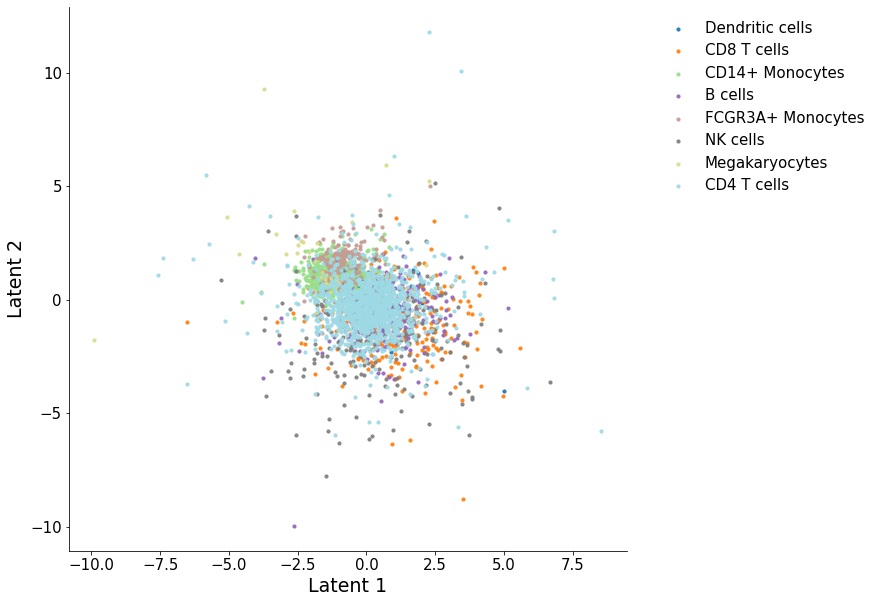

In [ ]:
# Get the output of the encoder(latent embedding) and visualize it with a scatter plot, complete the code below
with torch.no_grad():
    # note that ae_coordinates need to be transformed into numpy for the plot.
    ae_coordinates = model(expr_ctrl)[0].numpy()

plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "AE_untrained.pdf")

# Task 2: Design, train, and tune your own autoencoder


Now, it's your turn to design your own autoencoder architecture and tune the hyperparameters. <br>

Let's explore what architectures and hyperparameters are suited for our dataset. <br>

The only restriction of the architecture is that the embedding should be in two dimension, so we can visualize it.

Now, let's define a few things before we start training the autoencoder <br>


## Define an autoencoder with your own architecture

In [ ]:
#define your autoencoder architecture

class myAutoencoder(nn.Module):
    def __init__(self, in_features):
        '''
        in_features: number of features of the input data
        '''
        super(myAutoencoder,self).__init__()
        # TODO: complete the code 
        self.encode_layer1 = nn.Sequential(nn.Linear(100,500), nn.ReLU(), nn.Linear(500,250), nn.ReLU(), nn.Linear(250,50), nn.ReLU(), nn.Linear(50,2))
        self.decode_layer1 = nn.Sequential(nn.Linear(2,50), nn.ReLU(), nn.Linear(50,250), nn.ReLU(), nn.Linear(250,500), nn.ReLU(), nn.Linear(500,100))
    
    def forward(self, x):
        #TODO: complete the code for forward pass
        
        # embed is the output of the encoder
        embed = self.encode_layer1(x)
        # output is the output of the decoder
        output = self.decode_layer1(embed)
        return embed, output 



mymodel = myAutoencoder(in_features = expr_ctrl.shape[1])

## Define a loss function
A loss function is needed when training a DNN model. Here, we use **Mean Square Error(MSE) loss** for the autoencoder.



In [ ]:
loss_fcn = nn.MSELoss()

## Define the optimizer


To train the parameters of the autoencoder, we need to define an **optimizer** for the model. 

`PyTorch` provides a number of different optimizers for us to choose from. 

Adam optimizer is a popular optimizer that achieves good results and efficiency empirically.

Here we will use Adam optimizer(`optim.Adam`) for the optimization. 



In [ ]:
#TODO: define your learning rate
learning_rate = 0.01

optimizer = optim.Adam(mymodel.parameters(),
                       lr=learning_rate)

## Create a dataloader to load our samples in batch

`PyTorch` has an implemented dataloader for us to easily train our samples in batches. 
After defining a dataloader using our dataset, we can iterate over the samples in batches during training. 

In [ ]:
#TODO: define your batch size
batch_size = 250

from torch.utils.data import DataLoader
dataloader = DataLoader(expr_ctrl, batch_size=batch_size, shuffle=True)

## Train the autoencoder
Here we have arrived at the final step, which is to train the model. You will need to complete the function `train_model` to train the model.

In [ ]:
#define a training loop for the model

def train_model(model, dataloader, optimizer, loss_fcn, n_epochs=10):

    losses = []
    
    for epoch in range(n_epochs):
        
        for i, data_batch in enumerate(dataloader):
            #TODO: complete the function:
            # obtain the output from the model
            input = data_batch
            output = model(input)
            # get loss using the loss function we just defined
            loss = loss_fcn(output[1],input)
            
            #TODO: backpropagate the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.detach().item())

        print("Epoch: {} Loss: {:.3f}".format(epoch+1, loss.detach().item()))

    return model, losses

In [ ]:
n_epochs = 25
mymodel, losses = train_model(mymodel, dataloader,  optimizer = optimizer, loss_fcn = loss_fcn, n_epochs = n_epochs)

Epoch: 1 Loss: 4.886
Epoch: 2 Loss: 4.866
Epoch: 3 Loss: 4.780
Epoch: 4 Loss: 4.892
Epoch: 5 Loss: 4.343
Epoch: 6 Loss: 4.506
Epoch: 7 Loss: 3.795
Epoch: 8 Loss: 4.102
Epoch: 9 Loss: 3.734
Epoch: 10 Loss: 4.376
Epoch: 11 Loss: 3.666
Epoch: 12 Loss: 4.753
Epoch: 13 Loss: 3.738
Epoch: 14 Loss: 3.484
Epoch: 15 Loss: 4.688
Epoch: 16 Loss: 4.033
Epoch: 17 Loss: 4.104
Epoch: 18 Loss: 3.947
Epoch: 19 Loss: 3.638
Epoch: 20 Loss: 3.428
Epoch: 21 Loss: 3.986
Epoch: 22 Loss: 3.590
Epoch: 23 Loss: 3.648
Epoch: 24 Loss: 3.655
Epoch: 25 Loss: 3.504


Now, we can take a look at the losses obtained in each step during the training process

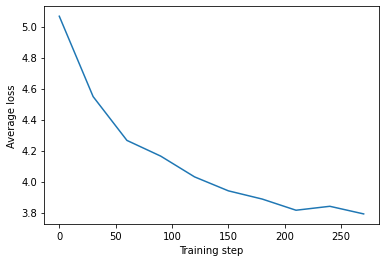

In [ ]:
PlotLoss(losses)
    

Execute the cell below and take a look at the scatter plot.
With training, the data embedding from the trained model should give a better representation of different cell types. <br>


Below is is an example of how a good embedding should look like.
Different cell types are more seperated from one another compared to the embedding from the untrained model. 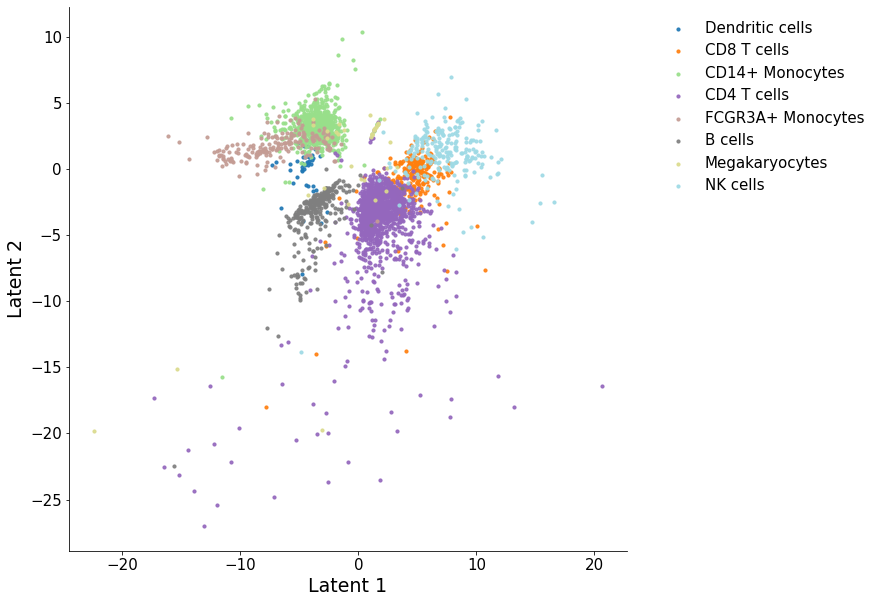

myAE.pdf


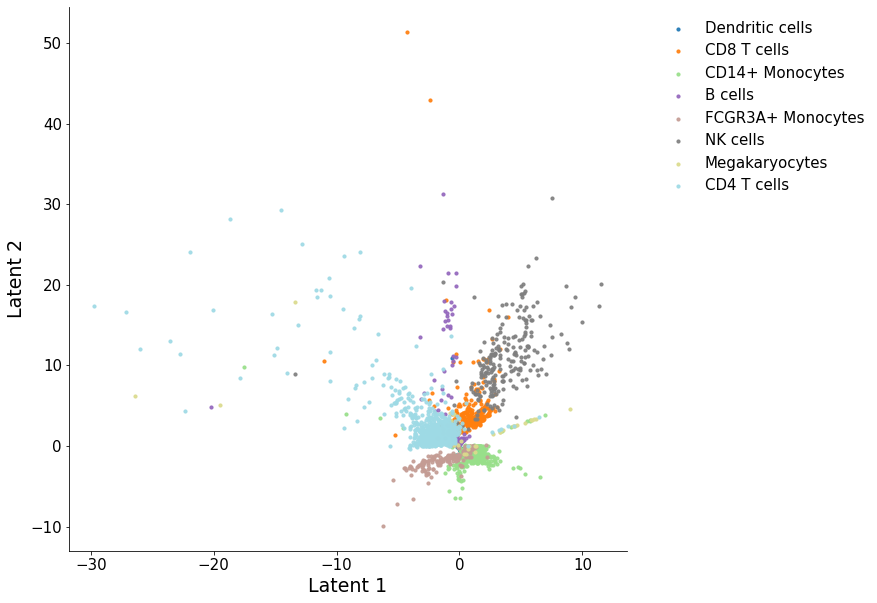

In [ ]:
# Get the output of the encoder(latent embedding) and visualize it with a scatter plot
with torch.no_grad():
    #you may need to modify this to get the embedding from mymodel if you change the embedding position
    # note that ae_coordinates need to be transformed into numpy for the plot.
    ae_coordinates = mymodel(expr_ctrl)[0].numpy()

plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "myAE.pdf")
